In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data = pd.read_csv("/home/mw/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1/Housing.csv")
data = data.dropna()

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

# Apply one-hot encoding for categorical columns
for col in categorical_columns:
    if data[col].nunique() <= 2:
        data[col] = LabelEncoder().fit_transform(data[col])
    else:
        one_hot = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data.drop(col, axis=1), one_hot], axis=1)

boolean_columns = data.select_dtypes(include='bool').columns
data[boolean_columns] = data[boolean_columns].astype(int)

numeric_columns = data.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
# data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Optionally, standardize target
target_column = "price"
target = data[target_column]
target = (target - target.mean()) / target.std()

data['area_standardized'] = (data['area'] - data['area'].mean()) / data['area'].std()
data['bedrooms_standardized'] = (data['bedrooms'] - data['bedrooms'].mean()) / data['bedrooms'].std()
data['bathrooms_standardized'] = (data['bathrooms'] - data['bathrooms'].mean()) / data['bathrooms'].std()
data['stories_standardized'] = (data['stories'] - data['stories'].mean()) / data['stories'].std()
data['parking_standardized'] = (data['parking'] - data['parking'].mean()) / data['parking'].std()

# Remove original columns after standardizing
data = data.drop(columns=['area', 'bedrooms', 'bathrooms', 'stories', 'parking', target_column])

features = data
print(features.head())

features_tensor = torch.tensor(features.values, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
print(data.columns)


Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')
   mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea  \
0         1          0         0                0                1         1   
1         1          0         0                0                1         0   
2         1          0         1                0                0         1   
3         1          0         1                0                1         1   
4         1          1         1                0                1         0   

   furnishingstatus_furnished  furnishingstatus_semi-furnished  \
0                           1                                0   
1                           1                                0   
2                           0                                1   
3                           1                                0   
4                           1                

In [2]:
import torch
from collections import Counter
from sklearn.model_selection import train_test_split

# Identify the problematic class
class_counts = Counter(target_tensor.numpy().flatten())
problematic_class = [k for k, v in class_counts.items() if v < 2]

# Filter out samples with the problematic class
mask = ~torch.isin(target_tensor, torch.tensor(problematic_class))

# Ensure mask is 1D (flatten it if necessary)
mask = mask.flatten()

filtered_features = features_tensor[mask]
filtered_targets = target_tensor[mask]

# Use the filtered dataset
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    filtered_features, filtered_targets, test_size=0.3, random_state=42, stratify=filtered_targets
)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim + condition_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.LeakyRelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, condition):
        # print("x ", x.shape)
        x = torch.cat([x, condition], dim=-1)  # Concatenate the condition to the input
        # print("concat :",x.shape )
        x = self.LeakyRelu(self.fc1(x))
        x = self.dropout(self.LeakyRelu(self.fc2(x)))
        x = self.LeakyRelu(self.fc3(x))
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim + condition_dim, 128)  # Latent + condition
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc_output = nn.Linear(512, output_dim)
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, z, condition):
        z = torch.cat([z, condition], dim=-1)  # Concatenate the condition to the latent
        z = self.lrelu(self.fc1(z))
        z = self.dropout(self.lrelu(self.fc2(z)))
        z = self.lrelu(self.fc3(z))
        reconstructed_x = self.sigmoid(self.fc_output(z))
        return reconstructed_x

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim,beta = 0.1):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, condition_dim)
        self.decoder = Decoder(latent_dim, input_dim, condition_dim)
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, condition):
        mu, log_var = self.encoder(x, condition)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decoder(z, condition)
        return reconstructed_x, mu, log_var

    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

  9%|▉         | 9/100 [00:00<00:04, 20.65it/s]

Epoch [1/100], Loss: 30.4213
Epoch [1/100], Train Loss: 30.4213, Val Loss: 17.5993
Epoch [2/100], Loss: 16.1968
Epoch [2/100], Train Loss: 16.1968, Val Loss: 11.2543
Epoch [3/100], Loss: 10.9517
Epoch [3/100], Train Loss: 10.9517, Val Loss: 6.8960
Epoch [4/100], Loss: 7.3802
Epoch [4/100], Train Loss: 7.3802, Val Loss: 4.0151
Epoch [5/100], Loss: 4.9279
Epoch [5/100], Train Loss: 4.9279, Val Loss: 2.8435
Epoch [6/100], Loss: 3.7706
Epoch [6/100], Train Loss: 3.7706, Val Loss: 2.1542
Epoch [7/100], Loss: 2.9787
Epoch [7/100], Train Loss: 2.9787, Val Loss: 1.7489
Epoch [8/100], Loss: 2.5748
Epoch [8/100], Train Loss: 2.5748, Val Loss: 1.5403
Epoch [9/100], Loss: 2.3078
Epoch [9/100], Train Loss: 2.3078, Val Loss: 1.3726
Epoch [10/100], Loss: 2.1013
Epoch [10/100], Train Loss: 2.1013, Val Loss: 1.2843
Epoch [11/100], Loss: 1.9314
Epoch [11/100], Train Loss: 1.9314, Val Loss: 1.1524
Epoch [12/100], Loss: 1.8158
Epoch [12/100], Train Loss: 1.8158, Val Loss: 1.1835
Epoch [13/100], Loss: 1.77

 23%|██▎       | 23/100 [00:00<00:01, 40.19it/s]

Epoch [15/100], Loss: 1.6212
Epoch [15/100], Train Loss: 1.6212, Val Loss: 1.0204
Epoch [16/100], Loss: 1.6151
Epoch [16/100], Train Loss: 1.6151, Val Loss: 1.0176
Epoch [17/100], Loss: 1.5744
Epoch [17/100], Train Loss: 1.5744, Val Loss: 1.0070
Epoch [18/100], Loss: 1.5576
Epoch [18/100], Train Loss: 1.5576, Val Loss: 0.9841
Epoch [19/100], Loss: 1.5249
Epoch [19/100], Train Loss: 1.5249, Val Loss: 0.9717
Epoch [20/100], Loss: 1.5157
Epoch [20/100], Train Loss: 1.5157, Val Loss: 0.9944
Epoch [21/100], Loss: 1.4934
Epoch [21/100], Train Loss: 1.4934, Val Loss: 0.9744
Epoch [22/100], Loss: 1.4565
Epoch [22/100], Train Loss: 1.4565, Val Loss: 0.9922
Epoch [23/100], Loss: 1.4575
Epoch [23/100], Train Loss: 1.4575, Val Loss: 0.9668
Epoch [24/100], Loss: 1.4681
Epoch [24/100], Train Loss: 1.4681, Val Loss: 1.0107
Epoch [25/100], Loss: 1.4742
Epoch [25/100], Train Loss: 1.4742, Val Loss: 0.9939
Epoch [26/100], Loss: 1.4401
Epoch [26/100], Train Loss: 1.4401, Val Loss: 1.0860
Epoch [27/100], 

 38%|███▊      | 38/100 [00:01<00:01, 54.87it/s]

Epoch [28/100], Loss: 1.4629
Epoch [28/100], Train Loss: 1.4629, Val Loss: 1.0188
Epoch [29/100], Loss: 1.4320
Epoch [29/100], Train Loss: 1.4320, Val Loss: 0.9618
Epoch [30/100], Loss: 1.4113
Epoch [30/100], Train Loss: 1.4113, Val Loss: 0.9389
Epoch [31/100], Loss: 1.3731
Epoch [31/100], Train Loss: 1.3731, Val Loss: 0.9493
Epoch [32/100], Loss: 1.3798
Epoch [32/100], Train Loss: 1.3798, Val Loss: 0.9310
Epoch [33/100], Loss: 1.3687
Epoch [33/100], Train Loss: 1.3687, Val Loss: 0.9258
Epoch [34/100], Loss: 1.3644
Epoch [34/100], Train Loss: 1.3644, Val Loss: 0.9341
Epoch [35/100], Loss: 1.3574
Epoch [35/100], Train Loss: 1.3574, Val Loss: 0.9285
Epoch [36/100], Loss: 1.3367
Epoch [36/100], Train Loss: 1.3367, Val Loss: 0.9163
Epoch [37/100], Loss: 1.3621
Epoch [37/100], Train Loss: 1.3621, Val Loss: 0.9209
Epoch [38/100], Loss: 1.3498
Epoch [38/100], Train Loss: 1.3498, Val Loss: 0.9129
Epoch [39/100], Loss: 1.3496
Epoch [39/100], Train Loss: 1.3496, Val Loss: 0.9099
Epoch [40/100], 

 55%|█████▌    | 55/100 [00:01<00:00, 67.05it/s]

Epoch [44/100], Loss: 1.3153
Epoch [44/100], Train Loss: 1.3153, Val Loss: 0.9023
Epoch [45/100], Loss: 1.3131
Epoch [45/100], Train Loss: 1.3131, Val Loss: 0.9016
Epoch [46/100], Loss: 1.3176
Epoch [46/100], Train Loss: 1.3176, Val Loss: 0.9021
Epoch [47/100], Loss: 1.3132
Epoch [47/100], Train Loss: 1.3132, Val Loss: 0.8988
Epoch [48/100], Loss: 1.3265
Epoch [48/100], Train Loss: 1.3265, Val Loss: 0.8991
Epoch [49/100], Loss: 1.3181
Epoch [49/100], Train Loss: 1.3181, Val Loss: 0.8994
Epoch [50/100], Loss: 1.3196
Epoch [50/100], Train Loss: 1.3196, Val Loss: 0.8989
Epoch [51/100], Loss: 1.3243
Epoch [51/100], Train Loss: 1.3243, Val Loss: 0.8986
Epoch [52/100], Loss: 1.3338
Epoch [52/100], Train Loss: 1.3338, Val Loss: 0.8985
Epoch [53/100], Loss: 1.3129
Epoch [53/100], Train Loss: 1.3129, Val Loss: 0.8974
Epoch [54/100], Loss: 1.2957
Epoch [54/100], Train Loss: 1.2957, Val Loss: 0.8965
Epoch [55/100], Loss: 1.3246
Epoch [55/100], Train Loss: 1.3246, Val Loss: 0.8959
Epoch [56/100], 

Epoch [59/100], Loss: 1.3296
Epoch [59/100], Train Loss: 1.3296, Val Loss: 0.8939
Epoch [60/100], Loss: 1.3224
Epoch [60/100], Train Loss: 1.3224, Val Loss: 0.8933
Epoch [61/100], Loss: 1.3162
Epoch [61/100], Train Loss: 1.3162, Val Loss: 0.8928
Epoch [62/100], Loss: 1.3012
Epoch [62/100], Train Loss: 1.3012, Val Loss: 0.8922
Epoch [63/100], Loss: 1.2961
Epoch [63/100], Train Loss: 1.2961, Val Loss: 0.8919
Epoch [64/100], Loss: 1.3032
Epoch [64/100], Train Loss: 1.3032, Val Loss: 0.8910
Epoch [65/100], Loss: 1.3175
Epoch [65/100], Train Loss: 1.3175, Val Loss: 0.8915
Epoch [66/100], Loss: 1.3029
Epoch [66/100], Train Loss: 1.3029, Val Loss: 0.8905
Epoch [67/100], Loss: 1.2976
Epoch [67/100], Train Loss: 1.2976, Val Loss: 0.8901
Epoch [68/100], Loss: 1.2890
Epoch [68/100], Train Loss: 1.2890, Val Loss: 0.8896
Epoch [69/100], Loss: 1.3088
Epoch [69/100], Train Loss: 1.3088, Val Loss: 0.8893
Epoch [70/100], Loss: 1.3102
Epoch [70/100], Train Loss: 1.3102, Val Loss: 0.8890
Epoch [71/100], 

 79%|███████▉  | 79/100 [00:01<00:00, 68.96it/s]

Epoch [71/100], Train Loss: 1.2927, Val Loss: 0.8890
Epoch [72/100], Loss: 1.2877
Epoch [72/100], Train Loss: 1.2877, Val Loss: 0.8891
Epoch [73/100], Loss: 1.3019
Epoch [73/100], Train Loss: 1.3019, Val Loss: 0.8889
Epoch [74/100], Loss: 1.2984
Epoch [74/100], Train Loss: 1.2984, Val Loss: 0.8882
Epoch [75/100], Loss: 1.3153
Epoch [75/100], Train Loss: 1.3153, Val Loss: 0.8878
Epoch [76/100], Loss: 1.2917
Epoch [76/100], Train Loss: 1.2917, Val Loss: 0.8878
Epoch [77/100], Loss: 1.2923
Epoch [77/100], Train Loss: 1.2923, Val Loss: 0.8874
Epoch [78/100], Loss: 1.3170
Epoch [78/100], Train Loss: 1.3170, Val Loss: 0.8872
Epoch [79/100], Loss: 1.2903
Epoch [79/100], Train Loss: 1.2903, Val Loss: 0.8874
Epoch [80/100], Loss: 1.2902
Epoch [80/100], Train Loss: 1.2902, Val Loss: 0.8871
Epoch [81/100], Loss: 1.2765
Epoch [81/100], Train Loss: 1.2765, Val Loss: 0.8868
Epoch [82/100], Loss: 1.2877
Epoch [82/100], Train Loss: 1.2877, Val Loss: 0.8867
Epoch [83/100], Loss: 1.2957
Epoch [83/100], 

 94%|█████████▍| 94/100 [00:01<00:00, 61.61it/s]

Epoch [86/100], Loss: 1.2938
Epoch [86/100], Train Loss: 1.2938, Val Loss: 0.8861
Epoch [87/100], Loss: 1.2987
Epoch [87/100], Train Loss: 1.2987, Val Loss: 0.8867
Epoch [88/100], Loss: 1.2980
Epoch [88/100], Train Loss: 1.2980, Val Loss: 0.8860
Epoch [89/100], Loss: 1.2833
Epoch [89/100], Train Loss: 1.2833, Val Loss: 0.8857
Epoch [90/100], Loss: 1.2963
Epoch [90/100], Train Loss: 1.2963, Val Loss: 0.8856
Epoch [91/100], Loss: 1.2792
Epoch [91/100], Train Loss: 1.2792, Val Loss: 0.8855
Epoch [92/100], Loss: 1.2858
Epoch [92/100], Train Loss: 1.2858, Val Loss: 0.8853
Epoch [93/100], Loss: 1.2790
Epoch [93/100], Train Loss: 1.2790, Val Loss: 0.8852
Epoch [94/100], Loss: 1.2967
Epoch [94/100], Train Loss: 1.2967, Val Loss: 0.8850
Epoch [95/100], Loss: 1.2886
Epoch [95/100], Train Loss: 1.2886, Val Loss: 0.8850
Epoch [96/100], Loss: 1.2918
Epoch [96/100], Train Loss: 1.2918, Val Loss: 0.8850


100%|██████████| 100/100 [00:01<00:00, 52.12it/s]


Epoch [97/100], Loss: 1.2880
Epoch [97/100], Train Loss: 1.2880, Val Loss: 0.8847
Epoch [98/100], Loss: 1.2973
Epoch [98/100], Train Loss: 1.2973, Val Loss: 0.8846
Epoch [99/100], Loss: 1.2928
Epoch [99/100], Train Loss: 1.2928, Val Loss: 0.8846
Epoch [100/100], Loss: 1.2995
Epoch [100/100], Train Loss: 1.2995, Val Loss: 0.8844


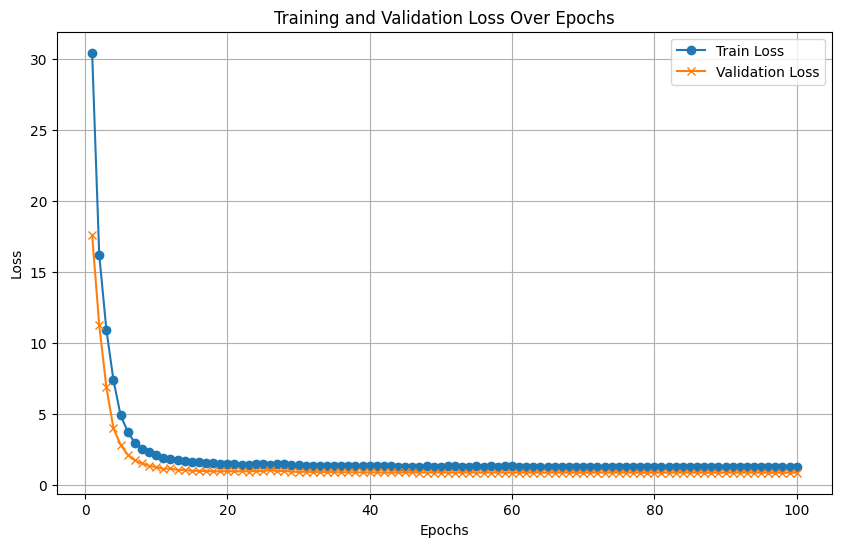

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming `features_tensor` and `target_tensor` are prepared and available
condition_dim = y_train_tensor.shape[1]  # Example: number of classes or other categorical input
input_dim = features_tensor.shape[1]
latent_dim = 100
beta = 0.4

# Define the VAE model (ensure that your model can handle `condition_dim` as input)
vae = VAE(input_dim, latent_dim, condition_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
reconstruction_loss_fn1 = nn.MSELoss(reduction="mean")
reconstruction_loss_fn = nn.L1Loss(reduction='mean')
reconstruction_loss_fn2 = nn.SmoothL1Loss(reduction='mean')

# Define the VAE loss function
def vae_loss(reconstructed_x, x, mu, log_var, beta=1.0):
    reconstruction_loss = reconstruction_loss_fn(reconstructed_x, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + beta * kl_divergence  # Apply beta scaling




# Convert to TensorDataset0.474925696849823
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop
num_epochs = 100  # Adjust epochs for demonstration
train_losses = []
val_losses = []


patience = 10  # Number of epochs without improvement before stopping
best_loss = float('inf')  # Initialize the best loss to infinity
epochs_without_improvement = 0 

for epoch in tqdm(range(num_epochs)):
    # Training phase
    vae.train()
    epoch_train_loss = 0
    for batch in train_loader:
        features, conditions = batch
        features = features.to(device)
        conditions = conditions.to(device)
        reconstructed_x, mu, log_var = vae(features, conditions)

        loss = vae_loss(reconstructed_x, features, mu, log_var, beta)
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss)
    if epoch_train_loss < best_loss:
        best_loss = epoch_train_loss
        epochs_without_improvement = 0  # Reset counter
        # Save model checkpoint when there's an improvement
        torch.save(vae.state_dict(), "best_vae_lrelu_model.pth")
    else:
        epochs_without_improvement += 1

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")

    # Validation phase
    vae.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            features, conditions = batch
            features = features.to(device)
            conditions = conditions.to(device)
            reconstructed_x, mu, log_var = vae(features, conditions)

            loss = vae_loss(reconstructed_x, features, mu, log_var)
            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss)

    tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import torch

# Reinitialize the VAE with the same architecture as used during training
vae = VAE(input_dim, latent_dim, condition_dim)  # Ensure these dimensions match your training setup
vae.load_state_dict(torch.load("best_vae_lrelu_model.pth"))
vae.eval()  # Set the model to evaluation mode
vae.to(device)  

/tmp/ipykernel_12599/585296845.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_vae_lrelu_model.pth"))


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=15, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc_mean): Linear(in_features=128, out_features=100, bias=True)
    (fc_log_var): Linear(in_features=128, out_features=100, bias=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=101, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=512, bias=True)
    (fc_output): Linear(in_features=512, out_features=14, bias=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [8]:
import torch

# Number of samples to generate
num_samples = 1000

# Sample from a standard normal distribution (mean=0, std=1) in the latent space
z = torch.randn(num_samples, latent_dim).to(device)

# Provide conditional input if the model is conditional (e.g., class labels, other inputs)
# Replace `condition_tensor` with appropriate conditional data for your problem
conditions = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Example: random class labels
conditions = torch.nn.functional.one_hot(conditions, num_classes=condition_dim).float()  # One-hot encode if needed

# Generate synthetic data
with torch.no_grad():
    # vae.  # Disable gradient computation
    generated_data = vae.decoder(z, conditions)  # Use the decoder to generate data


0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    0.0
96    1.0
97    1.0
98    1.0
99    1.0
Name: Feature_0, Length: 100, dtype: float32


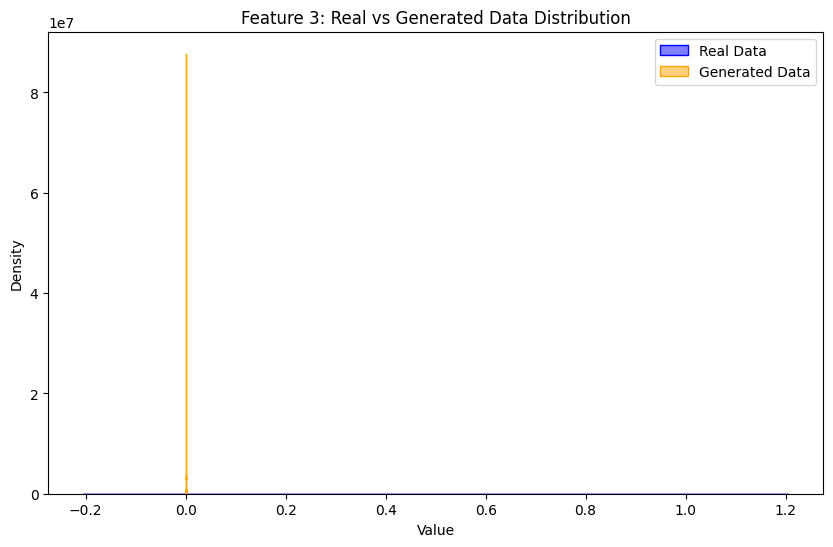

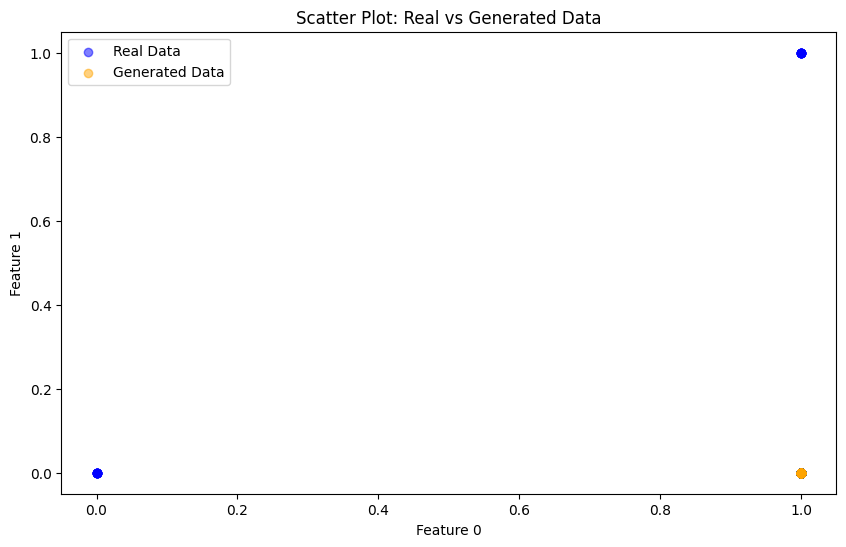

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have real data (X_real) and generated data (X_generated) as NumPy arrays
X_real_np = X_train_tensor.cpu().numpy()[:100]  # Sample 100 real data points
X_generated_np = generated_data.cpu().numpy()[:100]  # Sample 100 generated data points

# Convert to pandas DataFrame for easier plotting
real_df = pd.DataFrame(X_real_np, columns=[f"Feature_{i}" for i in range(X_real_np.shape[1])])
gen_df = pd.DataFrame(X_generated_np, columns=[f"Feature_{i}" for i in range(X_generated_np.shape[1])])

# Plot the distributions of a single feature for both real and generated data
feature_idx = 3  # Change this to plot a specific feature
print(real_df[f"Feature_0"])
plt.figure(figsize=(10, 6))
sns.kdeplot(real_df[f"Feature_{feature_idx}"], label="Real Data", color="blue", fill=True, alpha=0.5)
sns.kdeplot(gen_df[f"Feature_{feature_idx}"], label="Generated Data", color="orange", fill=True, alpha=0.5)
plt.title(f"Feature {feature_idx}: Real vs Generated Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Alternatively, scatter plot for two features
plt.figure(figsize=(10, 6))
plt.scatter(real_df[f"Feature_0"], real_df[f"Feature_1"], label="Real Data", color="blue", alpha=0.5)
plt.scatter(gen_df[f"Feature_0"], gen_df[f"Feature_1"], label="Generated Data", color="orange", alpha=0.5)
plt.title("Scatter Plot: Real vs Generated Data")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.show()


In [10]:
from torch.nn.functional import mse_loss
device = generated_data.device
loss = mse_loss(generated_data[:100].to(device), X_train_tensor[:100].to(device),reduction='mean')
print(f"Reconstruction Loss (MSE): {loss.item()}")

Reconstruction Loss (MSE): 0.47492551803588867


VAE-Ensemble

In [11]:
import torch.nn as nn
class VAEEnsemble(nn.Module):
    def __init__(self, num_models, latent_dim, output_dim, condition_dim):
        super(VAEEnsemble, self).__init__()
        self.num_models = num_models
        self.vae_models = nn.ModuleList([VAE(latent_dim, output_dim, condition_dim) for _ in range(num_models)])
        
    def forward(self, x, condition):
        reconstructed_x_list = []
        mu_list = []
        log_var_list = []
        
        # Forward pass through each VAE model in the ensemble
        for vae_model in self.vae_models:
            reconstructed_x, mu, log_var = vae_model(x, condition)
            reconstructed_x_list.append(reconstructed_x)
            mu_list.append(mu)
            log_var_list.append(log_var)
        
        # Combine the outputs from all models (simple averaging)
        reconstructed_x = torch.mean(torch.stack(reconstructed_x_list), dim=0)
        mu = torch.mean(torch.stack(mu_list), dim=0)
        log_var = torch.mean(torch.stack(log_var_list), dim=0)
        
        return reconstructed_x, mu, log_var


  9%|▉         | 9/100 [00:00<00:02, 39.53it/s]

Epoch [1/100], Train Loss: 10.5200, Val Loss: 4.0881
Epoch [2/100], Train Loss: 4.4683, Val Loss: 2.3228
Epoch [3/100], Train Loss: 3.0616, Val Loss: 1.6268
Epoch [4/100], Train Loss: 2.3415, Val Loss: 1.3560
Epoch [5/100], Train Loss: 1.9577, Val Loss: 1.2289
Epoch [6/100], Train Loss: 1.7680, Val Loss: 1.1155
Epoch [7/100], Train Loss: 1.6183, Val Loss: 1.0368
Epoch [8/100], Train Loss: 1.5382, Val Loss: 1.0110
Epoch [9/100], Train Loss: 1.4904, Val Loss: 0.9851


 18%|█▊        | 18/100 [00:00<00:02, 38.27it/s]

Epoch [10/100], Train Loss: 1.4638, Val Loss: 0.9720
Epoch [11/100], Train Loss: 1.4204, Val Loss: 0.9516
Epoch [12/100], Train Loss: 1.4177, Val Loss: 0.9355
Epoch [13/100], Train Loss: 1.3863, Val Loss: 0.9294
Epoch [14/100], Train Loss: 1.3748, Val Loss: 0.9171
Epoch [15/100], Train Loss: 1.3790, Val Loss: 0.9187
Epoch [16/100], Train Loss: 1.3510, Val Loss: 0.9089
Epoch [17/100], Train Loss: 1.3451, Val Loss: 0.9241
Epoch [18/100], Train Loss: 1.3499, Val Loss: 0.9052


 24%|██▍       | 24/100 [00:00<00:01, 43.86it/s]

Epoch [19/100], Train Loss: 1.3466, Val Loss: 0.9144
Epoch [20/100], Train Loss: 1.3268, Val Loss: 0.9046
Epoch [21/100], Train Loss: 1.3595, Val Loss: 0.9093
Epoch [22/100], Train Loss: 1.3327, Val Loss: 0.8967
Epoch [23/100], Train Loss: 1.3355, Val Loss: 0.9010
Epoch [24/100], Train Loss: 1.3164, Val Loss: 0.8947
Epoch [25/100], Train Loss: 1.3107, Val Loss: 0.8942
Epoch [26/100], Train Loss: 1.3058, Val Loss: 0.8957
Epoch [27/100], Train Loss: 1.3206, Val Loss: 0.8934
Epoch [28/100], Train Loss: 1.3303, Val Loss: 0.8968


 34%|███▍      | 34/100 [00:00<00:01, 41.82it/s]

Epoch [29/100], Train Loss: 1.3259, Val Loss: 0.8916
Epoch [30/100], Train Loss: 1.3095, Val Loss: 0.8951
Epoch [31/100], Train Loss: 1.3091, Val Loss: 0.8901
Epoch [32/100], Train Loss: 1.3091, Val Loss: 0.8916
Epoch [33/100], Train Loss: 1.2909, Val Loss: 0.8897
Epoch [34/100], Train Loss: 1.3241, Val Loss: 0.8910
Epoch [35/100], Train Loss: 1.3125, Val Loss: 0.8895
Epoch [36/100], Train Loss: 1.3054, Val Loss: 0.8916


 44%|████▍     | 44/100 [00:01<00:01, 39.04it/s]

Epoch [37/100], Train Loss: 1.3090, Val Loss: 0.8883
Epoch [38/100], Train Loss: 1.3038, Val Loss: 0.8895
Epoch [39/100], Train Loss: 1.2973, Val Loss: 0.8874
Epoch [40/100], Train Loss: 1.3048, Val Loss: 0.8878
Epoch [41/100], Train Loss: 1.2948, Val Loss: 0.8868
Epoch [42/100], Train Loss: 1.2904, Val Loss: 0.8874
Epoch [43/100], Train Loss: 1.2983, Val Loss: 0.8865
Epoch [44/100], Train Loss: 1.2900, Val Loss: 0.8861


 49%|████▉     | 49/100 [00:01<00:01, 39.02it/s]

Epoch [45/100], Train Loss: 1.3081, Val Loss: 0.8859
Epoch [46/100], Train Loss: 1.3142, Val Loss: 0.8857
Epoch [47/100], Train Loss: 1.2871, Val Loss: 0.8854
Epoch [48/100], Train Loss: 1.3014, Val Loss: 0.8850
Epoch [49/100], Train Loss: 1.2642, Val Loss: 0.8849
Epoch [50/100], Train Loss: 1.2993, Val Loss: 0.8850
Epoch [51/100], Train Loss: 1.3028, Val Loss: 0.8848
Epoch [52/100], Train Loss: 1.2876, Val Loss: 0.8843


 57%|█████▋    | 57/100 [00:01<00:01, 37.81it/s]

Epoch [53/100], Train Loss: 1.2992, Val Loss: 0.8842
Epoch [54/100], Train Loss: 1.2930, Val Loss: 0.8845
Epoch [55/100], Train Loss: 1.2903, Val Loss: 0.8841
Epoch [56/100], Train Loss: 1.2807, Val Loss: 0.8838
Epoch [57/100], Train Loss: 1.2960, Val Loss: 0.8837
Epoch [58/100], Train Loss: 1.3035, Val Loss: 0.8838
Epoch [59/100], Train Loss: 1.3195, Val Loss: 0.8836
Epoch [60/100], Train Loss: 1.2928, Val Loss: 0.8835
Epoch [61/100], Train Loss: 1.2763, Val Loss: 0.8831
Epoch [62/100], Train Loss: 1.2904, Val Loss: 0.8830


 69%|██████▉   | 69/100 [00:01<00:00, 46.32it/s]

Epoch [63/100], Train Loss: 1.2849, Val Loss: 0.8829
Epoch [64/100], Train Loss: 1.3199, Val Loss: 0.8830
Epoch [65/100], Train Loss: 1.3010, Val Loss: 0.8829
Epoch [66/100], Train Loss: 1.2936, Val Loss: 0.8827
Epoch [67/100], Train Loss: 1.3114, Val Loss: 0.8827
Epoch [68/100], Train Loss: 1.2984, Val Loss: 0.8825
Epoch [69/100], Train Loss: 1.3092, Val Loss: 0.8824
Epoch [70/100], Train Loss: 1.2919, Val Loss: 0.8824
Epoch [71/100], Train Loss: 1.2841, Val Loss: 0.8822
Epoch [72/100], Train Loss: 1.2927, Val Loss: 0.8822


 79%|███████▉  | 79/100 [00:01<00:00, 45.76it/s]

Epoch [73/100], Train Loss: 1.2667, Val Loss: 0.8821
Epoch [74/100], Train Loss: 1.2841, Val Loss: 0.8822
Epoch [75/100], Train Loss: 1.2871, Val Loss: 0.8820
Epoch [76/100], Train Loss: 1.2814, Val Loss: 0.8820
Epoch [77/100], Train Loss: 1.2810, Val Loss: 0.8820
Epoch [78/100], Train Loss: 1.2869, Val Loss: 0.8819
Epoch [79/100], Train Loss: 1.2726, Val Loss: 0.8819
Epoch [80/100], Train Loss: 1.2963, Val Loss: 0.8818
Epoch [81/100], Train Loss: 1.3131, Val Loss: 0.8818
Epoch [82/100], Train Loss: 1.2896, Val Loss: 0.8817
Epoch [83/100], Train Loss: 1.2815, Val Loss: 0.8817


 91%|█████████ | 91/100 [00:02<00:00, 51.96it/s]

Epoch [84/100], Train Loss: 1.2896, Val Loss: 0.8816
Epoch [85/100], Train Loss: 1.2837, Val Loss: 0.8816
Epoch [86/100], Train Loss: 1.2871, Val Loss: 0.8815
Epoch [87/100], Train Loss: 1.2777, Val Loss: 0.8816
Epoch [88/100], Train Loss: 1.2733, Val Loss: 0.8815
Epoch [89/100], Train Loss: 1.2880, Val Loss: 0.8815
Epoch [90/100], Train Loss: 1.2776, Val Loss: 0.8815
Epoch [91/100], Train Loss: 1.2829, Val Loss: 0.8814
Epoch [92/100], Train Loss: 1.2952, Val Loss: 0.8813
Epoch [93/100], Train Loss: 1.2773, Val Loss: 0.8814
Epoch [94/100], Train Loss: 1.3035, Val Loss: 0.8813
Epoch [95/100], Train Loss: 1.2786, Val Loss: 0.8813


100%|██████████| 100/100 [00:02<00:00, 42.83it/s]


Epoch [96/100], Train Loss: 1.2995, Val Loss: 0.8814
Epoch [97/100], Train Loss: 1.3104, Val Loss: 0.8813
Epoch [98/100], Train Loss: 1.2778, Val Loss: 0.8813
Epoch [99/100], Train Loss: 1.2802, Val Loss: 0.8812
Epoch [100/100], Train Loss: 1.2795, Val Loss: 0.8812


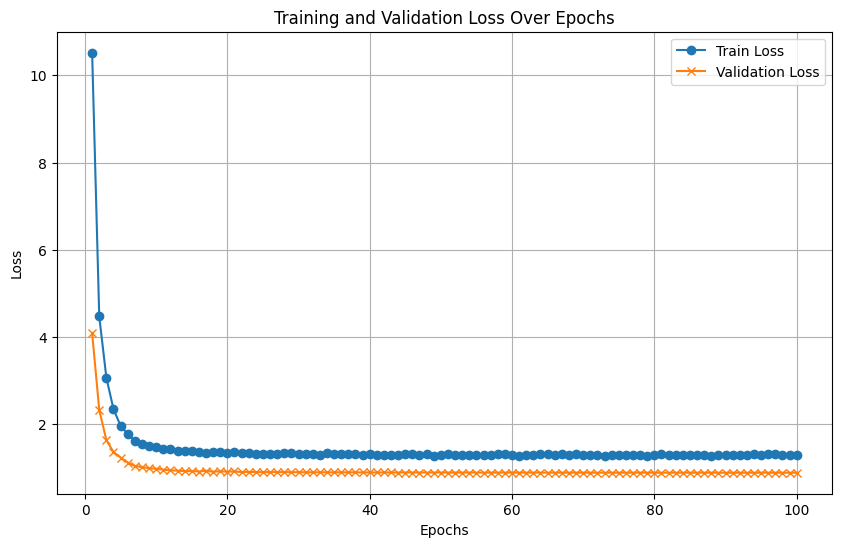

In [17]:
# Define the VAEEnsemble model
num_models = 3  # Set the number of models you want in the ensemble
vae_ensemble = VAEEnsemble(num_models, input_dim, latent_dim, condition_dim)
vae_ensemble.to(device)

optimizer = optim.Adam(vae_ensemble.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the VAE loss function (same as before)
def vae_loss(reconstructed_x, x, mu, log_var, beta=1.0):
    reconstruction_loss = reconstruction_loss_fn(reconstructed_x, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + beta * kl_divergence  # Apply beta scaling

# Training loop with VAEEnsemble
num_epochs = 100
train_losses = []
val_losses = []

patience = 10  # Number of epochs without improvement before stopping
best_loss = float('inf')  # Initialize the best loss to infinity
epochs_without_improvement = 0

for epoch in tqdm(range(num_epochs)):
    # Training phase
    vae_ensemble.train()
    epoch_train_loss = 0
    for batch in train_loader:
        features, conditions = batch
        features = features.to(device)
        conditions = conditions.to(device)

        # Forward pass through the ensemble
        reconstructed_x, mu, log_var = vae_ensemble(features, conditions)

        loss = vae_loss(reconstructed_x, features, mu, log_var, beta)
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss)
    if epoch_train_loss < best_loss:
        best_loss = epoch_train_loss
        epochs_without_improvement = 0  # Reset counter
        # Save model checkpoint when there's an improvement
        torch.save(vae_ensemble.state_dict(), "best_vae_ensemble_model.pth")
    else:
        epochs_without_improvement += 1

    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")

    # Validation phase
    vae_ensemble.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            features, conditions = batch
            features = features.to(device)
            conditions = conditions.to(device)
            
            reconstructed_x, mu, log_var = vae_ensemble(features, conditions)

            loss = vae_loss(reconstructed_x, features, mu, log_var)
            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss)
    tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Reinitialize the VAEEnsemble with the same number of models and dimensions
num_models = 3  # Use the number of models you trained in the ensemble
vae_ensemble = VAEEnsemble(num_models, input_dim, latent_dim, condition_dim)
vae_ensemble.load_state_dict(torch.load("best_vae_ensemble_model.pth"))
vae_ensemble.eval()  # Set the ensemble model to evaluation mode
vae_ensemble.to(device)


/tmp/ipykernel_12599/2687919388.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_ensemble.load_state_dict(torch.load("best_vae_ensemble_model.pth"))


VAEEnsemble(
  (vae_models): ModuleList(
    (0-2): 3 x VAE(
      (encoder): Encoder(
        (fc1): Linear(in_features=15, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=128, bias=True)
        (fc_mean): Linear(in_features=128, out_features=100, bias=True)
        (fc_log_var): Linear(in_features=128, out_features=100, bias=True)
        (LeakyRelu): LeakyReLU(negative_slope=0.01)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (decoder): Decoder(
        (fc1): Linear(in_features=101, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=512, bias=True)
        (fc_output): Linear(in_features=512, out_features=14, bias=True)
        (lrelu): LeakyReLU(negative_slope=0.01)
        (sigmoid): Sigmoid()
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
  )
)

In [19]:
import torch

# Assuming you have `device` set, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of samples to generate
num_samples = 1000

# Sample from a standard normal distribution (mean=0, std=1) in the latent space
z = torch.randn(num_samples, latent_dim).to(device)  # Ensure z is on the same device as the model

# Provide conditional input if the model is conditional (e.g., class labels, other inputs)
# Replace `condition_tensor` with appropriate conditional data for your problem
conditions = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Random class labels
conditions = torch.nn.functional.one_hot(conditions, num_classes=condition_dim).float()  # One-hot encode if needed

# Ensure the VAE is in evaluation mode
vae.eval()

# Generate synthetic data
with torch.no_grad():  # Disable gradient computation
    # Ensure the conditions are also on the same device as z and vae
    conditions = conditions.to(device)
    generated_data = vae.decoder(z, conditions)  # Use the decoder to generate data

# `generated_data` is the output synthetic data, which you can use for further analysis, visualization, etc.
print(generated_data.shape)  # Check the shape of the generated data


torch.Size([1000, 14])


0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    0.0
96    1.0
97    1.0
98    1.0
99    1.0
Name: Feature_0, Length: 100, dtype: float32


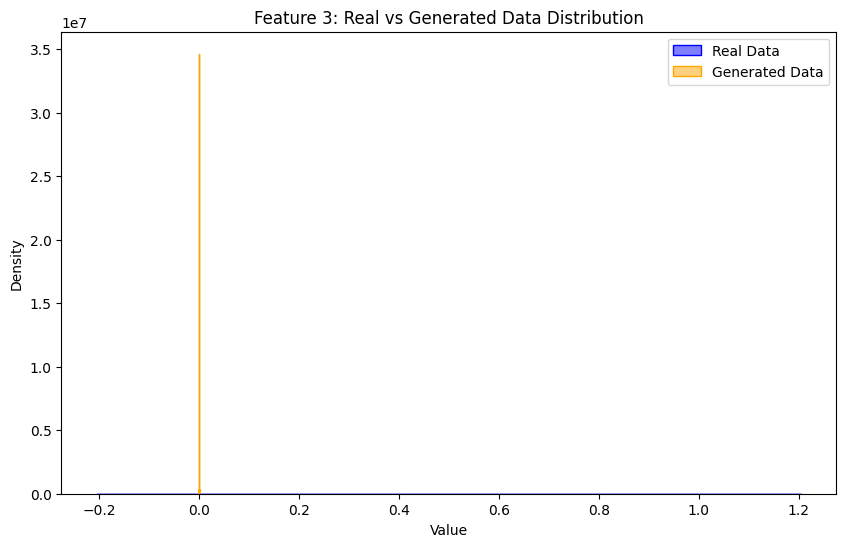

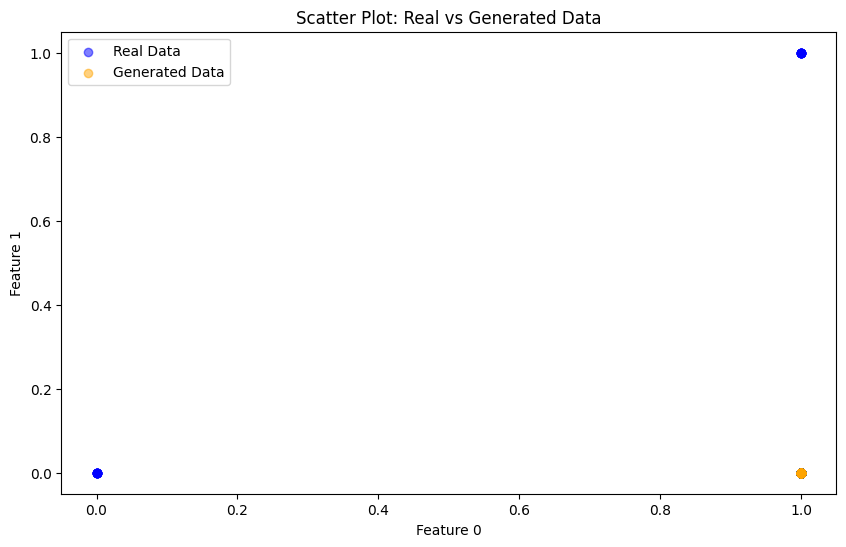

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have real data (X_real) and generated data (X_generated) as NumPy arrays
X_real_np = X_train_tensor.cpu().numpy()[:100]  # Sample 100 real data points
X_generated_np = generated_data.cpu().numpy()[:100]  # Sample 100 generated data points

# Convert to pandas DataFrame for easier plotting
real_df = pd.DataFrame(X_real_np, columns=[f"Feature_{i}" for i in range(X_real_np.shape[1])])
gen_df = pd.DataFrame(X_generated_np, columns=[f"Feature_{i}" for i in range(X_generated_np.shape[1])])

# Plot the distributions of a single feature for both real and generated data
feature_idx = 3  # Change this to plot a specific feature
print(real_df[f"Feature_0"])
plt.figure(figsize=(10, 6))
sns.kdeplot(real_df[f"Feature_{feature_idx}"], label="Real Data", color="blue", fill=True, alpha=0.5)
sns.kdeplot(gen_df[f"Feature_{feature_idx}"], label="Generated Data", color="orange", fill=True, alpha=0.5)
plt.title(f"Feature {feature_idx}: Real vs Generated Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Alternatively, scatter plot for two features
plt.figure(figsize=(10, 6))
plt.scatter(real_df[f"Feature_0"], real_df[f"Feature_1"], label="Real Data", color="blue", alpha=0.5)
plt.scatter(gen_df[f"Feature_0"], gen_df[f"Feature_1"], label="Generated Data", color="orange", alpha=0.5)
plt.title("Scatter Plot: Real vs Generated Data")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.show()


In [21]:
from torch.nn.functional import mse_loss
device = generated_data.device
loss = mse_loss(generated_data[:100].to(device), X_train_tensor[:100].to(device),reduction='mean')
print(f"Reconstruction Loss (MSE): {loss.item()}")

Reconstruction Loss (MSE): 0.474925696849823
